# Plot Byzantine simulation charts

This notebook loads the CSV exported from the simulator and plots the Energy and Alive series per algorithm. Update the `CSV_PATH` variable if your file is located elsewhere.

Found sink-position files: ['sink_position/byzantine-charts-2025-10-17T04-25-23-149Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-25-48-219Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-26-29-564Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-26-52-339Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-27-19-307Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-27-39-384Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-48-19-077Z_200x200.csv']
{'87x87': 3, '100x100': 3, '200x200': 1}
Found cluster files: ['cluster/byzantine-charts-2025-10-17T04-41-57-444Z_c3.csv', 'cluster/byzantine-charts-2025-10-17T04-42-17-471Z_c5.csv', 'cluster/byzantine-charts-2025-10-17T04-42-36-420Z_c7.csv', 'cluster/byzantine-charts-2025-10-17T04-43-15-244Z_c7.csv', 'cluster/byzantine-charts-2025-10-17T04-43-36-372Z_c5.csv', 'cluster/byzantine-charts-2025-10-17T04-43-53-933Z_c3.csv']
{'c3': 2, 'c5': 2, 'c7': 2}
Saved averaged BCA cluster com

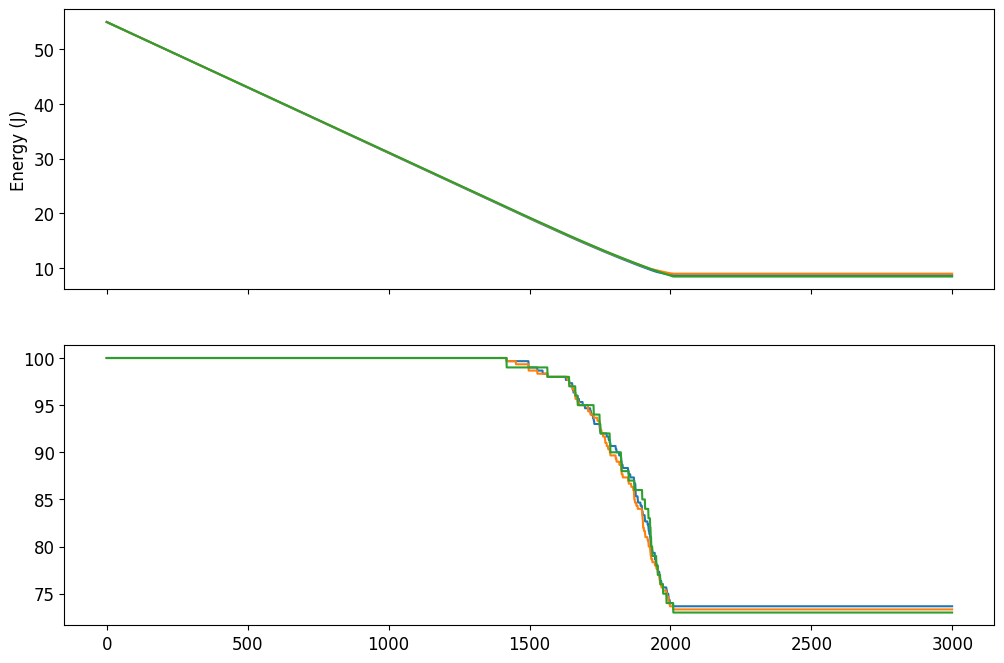

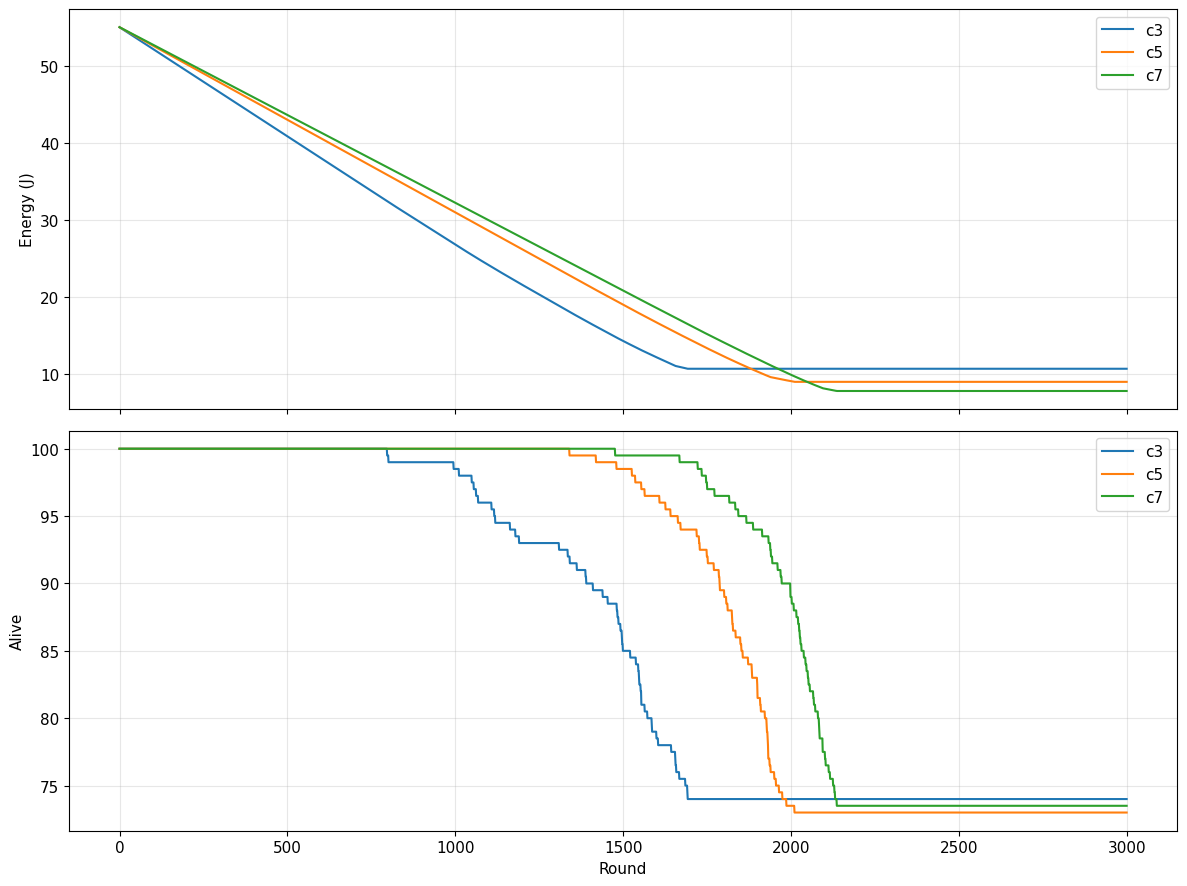

Found sink-position files: ['sink_position/byzantine-charts-2025-10-17T04-25-23-149Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-25-48-219Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-26-29-564Z_87x87.csv', 'sink_position/byzantine-charts-2025-10-17T04-26-52-339Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-27-19-307Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-27-39-384Z_100x100.csv', 'sink_position/byzantine-charts-2025-10-17T04-48-19-077Z_200x200.csv']
{'87x87': 3, '100x100': 3, '200x200': 1}


In [15]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
CSV_DIR = Path('sink_position')
out_png = CSV_DIR / 'bca_sink_compare.png'
files = sorted(CSV_DIR.glob('*.csv'))
print('Found sink-position files:', [str(p) for p in files])
# Group files by target position keywords
groups = {'87x87': [], '100x100': [], '200x200': []}
for p in files:
    name = p.stem.lower()
    if '87' in name or '87x87' in name:
        groups['87x87'].append(p)
    elif '100' in name or '100x100' in name:
        groups['100x100'].append(p)
    elif '200' in name or '200x200' in name:
        groups['200x200'].append(p)
print({k: len(v) for k,v in groups.items()})
def load_energy_alive(p):
    df = pd.read_csv(p)
    if 'Round' in df.columns:
        df = df.set_index('Round')
    cols = list(df.columns)
    ecol = None
    acol = None
    # prefer columns mentioning 'bca' and 'energy'/'alive'
    for c in cols:
        low = c.lower()
        if 'bca' in low and 'energy' in low: ecol = c
        if 'bca' in low and 'alive' in low: acol = c
    # fallback: first column containing 'energy'
    if ecol is None:
        for i,c in enumerate(cols):
            if 'energy' in c.lower(): ecol = c; break
    # try find an 'alive' column
    if acol is None and ecol is not None:
        for c in cols:
            if 'alive' in c.lower(): acol = c; break
    # if still not found, try neighbor column after an energy column
    if acol is None and ecol is not None:
        ei = cols.index(ecol)
        if ei+1 < len(cols): acol = cols[ei+1]
    # prepare index (rounds) and return two series (may contain NaN)
    if df.index.name == 'Round' or df.index.dtype.kind in 'iu':
        idx = df.index
    else:
        idx = pd.Index(range(len(df)))
    e = df[ecol] if ecol and ecol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    a = df[acol] if acol and acol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    e.index = idx; a.index = idx
    return e, a
# For each group, load files and compute per-round mean
group_avg = {}
for g, plist in groups.items():
    dfs_e = []
    dfs_a = []
    for p in plist:
        try:
            e,a = load_energy_alive(p)
        except Exception as ex:
            print('skip', p, 'err', ex)
            continue
        dfs_e.append(e.rename(str(p)))
        dfs_a.append(a.rename(str(p)))
    if not dfs_e:
        print('No files for', g)
        continue
    # create union of rounds and reindex
    all_rounds = sorted(set().union(*[list(s.index) for s in dfs_e]))
    all_rounds = pd.Index(all_rounds)
    re_e = [s.reindex(all_rounds) for s in dfs_e]
    re_a = [s.reindex(all_rounds) for s in dfs_a] if dfs_a else []
    mean_e = pd.concat(re_e, axis=1).mean(axis=1)
    mean_a = pd.concat(re_a, axis=1).mean(axis=1) if re_a else pd.Series([pd.NA]*len(all_rounds), index=all_rounds)
    group_avg[g] = (all_rounds, mean_e, mean_a)
# Plot the two averaged groups (Energy + Alive) if available
if not group_avg:
    print('No averaged groups to plot')
else:
    plt.rcParams.update({'figure.figsize': (12,8), 'font.size': 12})
    fig, axes = plt.subplots(2,1,sharex=True)
    colors = {'87x87': 'tab:blue', '100x100':'tab:orange', '200x200':'tab:green'}
    for g in ['87x87','100x100', '200x200']:
        if g not in group_avg: continue
        rounds, mean_e, mean_a = group_avg[g]
        axes[0].plot(rounds, mean_e, label=g, color=colors.get(g))
        axes[1].plot(rounds, mean_a, label=g, color=colors.get(g))
    axes[0].set_ylabel('Energy (J)')
# Average and compare BCA results for cluster sizes c3, c5, c7 located in cluster/
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
CSV_DIR = Path('cluster')
out_png = CSV_DIR / 'bca_cluster_compare.png'
files = sorted(CSV_DIR.glob('*.csv'))
print('Found cluster files:', [str(p) for p in files])
# Group files by cluster keyword
groups = {'c3': [], 'c5': [], 'c7': []}
for p in files:
    name = p.stem.lower()
    if 'c3' in name: groups['c3'].append(p)
    elif 'c5' in name: groups['c5'].append(p)
    elif 'c7' in name: groups['c7'].append(p)
print({k: len(v) for k,v in groups.items()})
def load_energy_alive(p):
    df = pd.read_csv(p)
    if 'Round' in df.columns:
        df = df.set_index('Round')
    cols = list(df.columns)
    ecol = None
    acol = None
    for c in cols:
        low = c.lower()
        if 'bca' in low and 'energy' in low: ecol = c
        if 'bca' in low and 'alive' in low: acol = c
    if ecol is None:
        for i,c in enumerate(cols):
            if 'energy' in c.lower(): ecol = c; break
    if acol is None and ecol is not None:
        for c in cols:
            if 'alive' in c.lower(): acol = c; break
    if acol is None and ecol is not None:
        ei = cols.index(ecol)
        if ei+1 < len(cols): acol = cols[ei+1]
    if df.index.name == 'Round' or df.index.dtype.kind in 'iu':
        idx = df.index
    else:
        idx = pd.Index(range(len(df)))
    e = df[ecol] if ecol and ecol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    a = df[acol] if acol and acol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    e.index = idx; a.index = idx
    return e, a
group_avg = {}
for g, plist in groups.items():
    dfs_e = []
    dfs_a = []
    for p in plist:
        try:
            e,a = load_energy_alive(p)
        except Exception as ex:
            print('skip', p, 'err', ex)
            continue
        dfs_e.append(e.rename(str(p)))
        dfs_a.append(a.rename(str(p)))
    if not dfs_e:
        print('No files for', g)
        continue
    all_rounds = sorted(set().union(*[list(s.index) for s in dfs_e]))
    all_rounds = pd.Index(all_rounds)
    re_e = [s.reindex(all_rounds) for s in dfs_e]
    re_a = [s.reindex(all_rounds) for s in dfs_a] if dfs_a else []
    mean_e = pd.concat(re_e, axis=1).mean(axis=1)
    mean_a = pd.concat(re_a, axis=1).mean(axis=1) if re_a else pd.Series([pd.NA]*len(all_rounds), index=all_rounds)
    group_avg[g] = (all_rounds, mean_e, mean_a)
if not group_avg:
    print('No averaged groups to plot')
else:
    plt.rcParams.update({'figure.figsize': (12,9), 'font.size': 11})
    fig, axes = plt.subplots(2,1,sharex=True)
    colors = {'c3':'tab:blue','c5':'tab:orange','c7':'tab:green'}
    for g in ['c3','c5','c7']:
        if g not in group_avg: continue
        rounds, mean_e, mean_a = group_avg[g]
        axes[0].plot(rounds, mean_e, label=g, color=colors.get(g))
        axes[1].plot(rounds, mean_a, label=g, color=colors.get(g))
    axes[0].set_ylabel('Energy (J)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[1].set_ylabel('Alive')
    axes[1].set_xlabel('Round')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    os.makedirs(CSV_DIR, exist_ok=True)
    fig.savefig(out_png, dpi=150)
    print('Saved averaged BCA cluster comparison to', out_png)
    plt.show()

# Average and compare BCA results for sink positions 87x87 and 100x100
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
CSV_DIR = Path('sink_position')
out_png = CSV_DIR / 'bca_sink_compare.png'
files = sorted(CSV_DIR.glob('*.csv'))
print('Found sink-position files:', [str(p) for p in files])
# Group files by target position keywords
groups = {'87x87': [], '100x100': [], '200x200': []}
for p in files:
    name = p.stem.lower()
    if '87' in name or '87x87' in name:
        groups['87x87'].append(p)
    elif '100' in name or '100x100' in name:
        groups['100x100'].append(p)
    elif '200' in name or '200x200' in name:
        groups['200x200'].append(p)
print({k: len(v) for k,v in groups.items()})
def load_energy_alive(p):
    df = pd.read_csv(p)
    if 'Round' in df.columns:
        df = df.set_index('Round')
    cols = list(df.columns)
    ecol = None; acol = None
    # prefer columns mentioning 'bca' and 'energy'/'alive'
    for c in cols:
        low = c.lower()
        if 'bca' in low and 'energy' in low: ecol = c
        if 'bca' in low and 'alive' in low: acol = c
    # fallback: first column containing 'energy' and its next column for alive
    if ecol is None:
        for i,c in enumerate(cols):
            if 'energy' in c.lower(): ecol = c; break
    if acol is None and ecol is not None:
        # try find an 'alive' column
        for c in cols:
            if 'alive' in c.lower(): acol = c; break
    # if still not found, try neighbor column after an energy column
    if acol is None and ecol is not None:
        ei = cols.index(ecol)
        if ei+1 < len(cols): acol = cols[ei+1]
    # prepare index (rounds) and return two series (may contain NaN)
    if df.index.name == 'Round' or df.index.dtype.kind in 'iu':
        idx = df.index
    else:
        idx = pd.Index(range(len(df)))
    e = df[ecol] if ecol and ecol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    a = df[acol] if acol and acol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    e.index = idx; a.index = idx
    return e, a
# For each group, load files and compute per-round mean
group_avg = {}
for g, plist in groups.items():
    dfs_e = []; dfs_a = []
    for p in plist:
        try:
            e,a = load_energy_alive(p)
        except Exception as ex:
            print('skip', p, 'err', ex); continue
        dfs_e.append(e.rename(str(p)))
        dfs_a.append(a.rename(str(p)))
    if not dfs_e:
        print('No files for', g); continue
    # create union of rounds and reindex
    all_rounds = sorted(set().union(*[list(s.index) for s in dfs_e]))
    all_rounds = pd.Index(all_rounds)
    re_e = [s.reindex(all_rounds) for s in dfs_e]


Found algo_comp files: ['algo_comp/byzantine-charts-2025-10-17T04-02-57-555Z.csv', 'algo_comp/byzantine-charts-2025-10-17T04-22-49-177Z_ft1-3.csv', 'algo_comp/byzantine-charts-2025-10-17T04-23-43-468Z_ft1-2.csv', 'algo_comp/byzantine-charts-2025-10-17T04-24-13-045Z_ft1-4.csv', 'algo_comp/byzantine-charts-2025-10-17T04-25-23-149Z_87x87.csv', 'algo_comp/byzantine-charts-2025-10-17T04-25-48-219Z_87x87.csv', 'algo_comp/byzantine-charts-2025-10-17T04-26-29-564Z_87x87.csv', 'algo_comp/byzantine-charts-2025-10-17T04-26-52-339Z_100x100.csv', 'algo_comp/byzantine-charts-2025-10-17T04-27-19-307Z_100x100.csv', 'algo_comp/byzantine-charts-2025-10-17T04-27-39-384Z_100x100.csv', 'algo_comp/byzantine-charts-2025-10-17T04-41-57-444Z_c3.csv', 'algo_comp/byzantine-charts-2025-10-17T04-42-17-471Z_c5.csv', 'algo_comp/byzantine-charts-2025-10-17T04-42-36-420Z_c7.csv', 'algo_comp/byzantine-charts-2025-10-17T04-43-15-244Z_c7.csv', 'algo_comp/byzantine-charts-2025-10-17T04-43-36-372Z_c5.csv', 'algo_comp/byzan

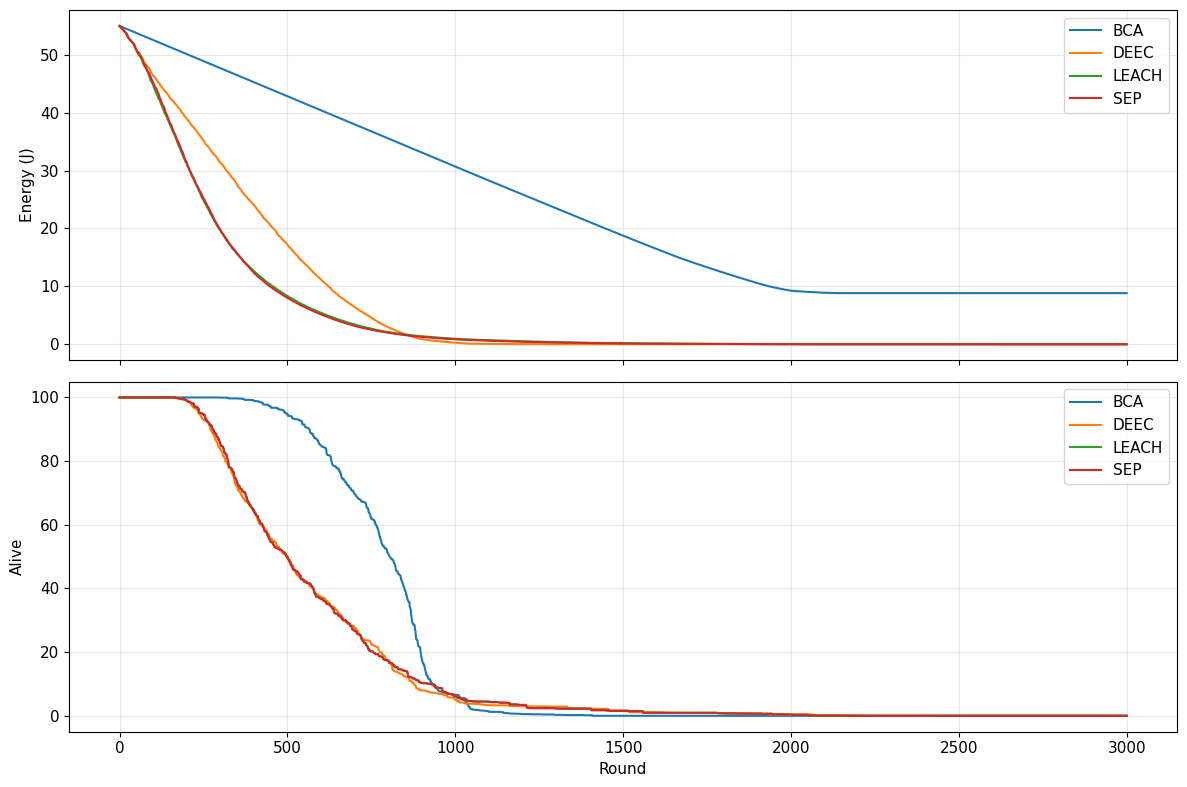

In [16]:
# Load all CSVs in algo_comp/, align and average columns across files, then plot per-algorithm Energy and Alive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
CSV_DIR = Path('algo_comp')
out_png = CSV_DIR / 'bca_algo_compare.png'
files = sorted(CSV_DIR.glob('*.csv'))
print('Found algo_comp files:', [str(p) for p in files])
if not files:
    print('No files in algo_comp/ -- nothing to plot')
else:
    # Read all CSVs and keep common columns if possible, otherwise align by union and average where present
    dfs = []
    for p in files:
        d = pd.read_csv(p)
        if 'Round' in d.columns:
            d = d.set_index('Round')
        dfs.append(d)
    # Build union of rounds across files
    all_rounds = sorted(set().union(*[list(d.index) for d in dfs]))
    all_rounds = pd.Index(all_rounds)
    # Reindex each df to union and collect columns
    reindexed = [d.reindex(all_rounds) for d in dfs]
    # Determine full set of columns present across files
    all_cols = sorted(set().union(*[set(d.columns) for d in reindexed]))
    # For each column, build a matrix and average across files (skip NaNs)
    avg_df = pd.DataFrame(index=all_rounds)
    for c in all_cols:
        stacked = pd.concat([d[c] for d in reindexed], axis=1)
        avg_df[c] = stacked.mean(axis=1)
    # Now parse avg_df columns to find algorithm labels; assume pairs like '<ALG> Energy (J)' and '<ALG> Alive'
    cols = list(avg_df.columns)
    labels = []
    i = 0
    while i < len(cols):
        col = cols[i]
        if 'energy' in col.lower():
            # try to extract label prefix
            lab = col.replace(' Energy (J)', '').strip() if 'energy' in col.lower() else col
            # find alive column next to it or by name
            alive_col = None
            if i+1 < len(cols) and 'alive' in cols[i+1].lower(): alive_col = cols[i+1]
            else:
                for c2 in cols:
                    if 'alive' in c2.lower() and c2.startswith(lab): alive_col = c2; break
            labels.append((lab, col, alive_col))
            i += 1
        i += 1
    # Plot Energy and Alive per algorithm
    plt.rcParams.update({'figure.figsize': (12,8), 'font.size': 11})
    fig, axes = plt.subplots(2,1,sharex=True)
    for lab, ecol, acol in labels:
        if ecol in avg_df.columns:
            axes[0].plot(all_rounds, avg_df[ecol], label=lab)
        if acol and acol in avg_df.columns:
            axes[1].plot(all_rounds, avg_df[acol], label=lab)
    axes[0].set_ylabel('Energy (J)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[1].set_ylabel('Alive')
    axes[1].set_xlabel('Round')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    os.makedirs(CSV_DIR, exist_ok=True)
    fig.savefig(out_png, dpi=150)
    print('Saved averaged algorithm comparison to', out_png)
    plt.show()

Found FT files: ['Ft/byzantine-charts-2025-10-17T04-22-49-177Z_ft1-3.csv', 'Ft/byzantine-charts-2025-10-17T04-23-43-468Z_ft1-2.csv', 'Ft/byzantine-charts-2025-10-17T04-24-13-045Z_ft1-4.csv']
{'ft1-2': 1, 'ft1-3': 1, 'ft1-4': 1}
Saved BCA FT comparison to Ft/bca_ft_compare.png


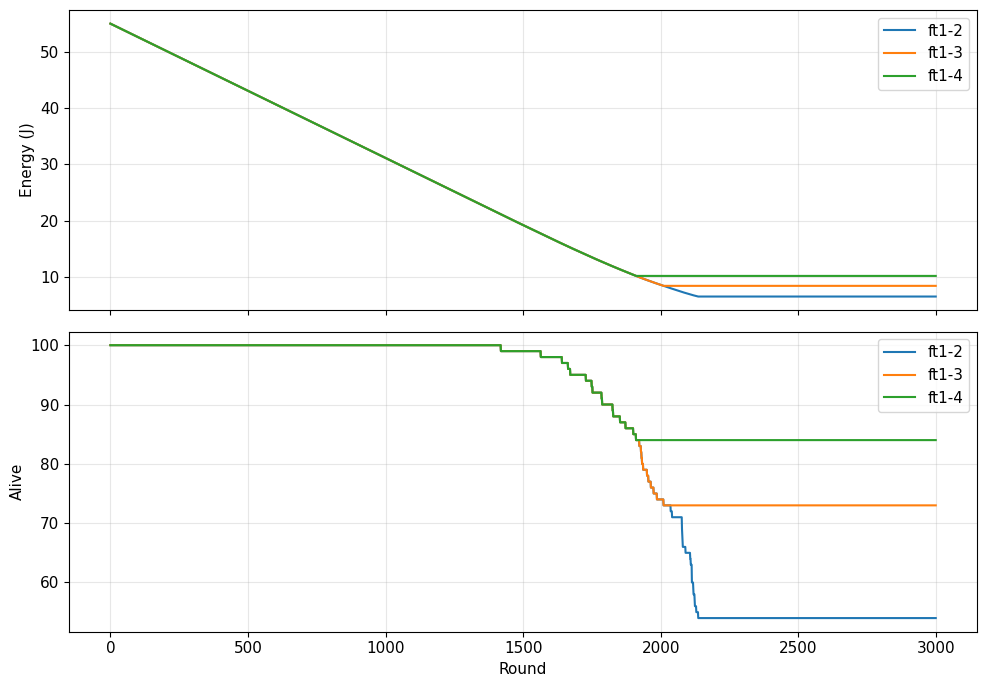

In [18]:
# Compare only BCA algorithm across FT groups (ft1-2, ft1-3, ft1-4) in folder FT/
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
CSV_DIR = Path('Ft')
out_png = CSV_DIR / 'bca_ft_compare.png'
files = sorted(CSV_DIR.glob('*.csv'))
print('Found FT files:', [str(p) for p in files])
groups = {'ft1-2': [], 'ft1-3': [], 'ft1-4': []}
for p in files:
    name = p.stem.lower()
    if 'ft1-2' in name or '1-2' in name: groups['ft1-2'].append(p)
    elif 'ft1-3' in name or '1-3' in name: groups['ft1-3'].append(p)
    elif 'ft1-4' in name or '1-4' in name: groups['ft1-4'].append(p)
print({k: len(v) for k,v in groups.items()})
def load_bca(p):
    df = pd.read_csv(p)
    if 'Round' in df.columns:
        df = df.set_index('Round')
    cols = list(df.columns)
    ecol = None; acol = None
    for c in cols:
        low = c.lower()
        if low.startswith('bca') and 'energy' in low: ecol = c
        if low.startswith('bca') and 'alive' in low: acol = c
    # fallback heuristics
    if ecol is None:
        for c in cols:
            if 'energy' in c.lower(): ecol = c; break
    if acol is None:
        for c in cols:
            if 'alive' in c.lower(): acol = c; break
    if ecol is None: ecol = cols[0]
    if acol is None and len(cols)>1: acol = cols[1]
    idx = df.index if df.index.name=='Round' or df.index.dtype.kind in 'iu' else pd.Index(range(len(df)))
    e = df[ecol] if ecol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    a = df[acol] if acol in df.columns else pd.Series([pd.NA]*len(idx), index=idx)
    e.index = idx; a.index = idx
    return e, a
group_avg = {}
for g, plist in groups.items():
    es = []; as_ = []
    for p in plist:
        try:
            e,a = load_bca(p)
        except Exception as ex:
            print('skip', p, 'err', ex); continue
        es.append(e.rename(str(p)))
        as_.append(a.rename(str(p)))
    if not es: print('No files for', g); continue
    all_rounds = sorted(set().union(*[list(s.index) for s in es]))
    all_rounds = pd.Index(all_rounds)
    re_e = [s.reindex(all_rounds) for s in es]
    re_a = [s.reindex(all_rounds) for s in as_]
    mean_e = pd.concat(re_e, axis=1).mean(axis=1)
    mean_a = pd.concat(re_a, axis=1).mean(axis=1)
    group_avg[g] = (all_rounds, mean_e, mean_a)
# Plot
if not group_avg: print('Nothing to plot for FT groups')
else:
    plt.rcParams.update({'figure.figsize': (10,7),'font.size':11})
    fig, axes = plt.subplots(2,1,sharex=True)
    colors = {'ft1-2':'tab:blue','ft1-3':'tab:orange','ft1-4':'tab:green'}
    for g in ['ft1-2','ft1-3','ft1-4']:
        if g not in group_avg: continue
        rounds, me, ma = group_avg[g]
        axes[0].plot(rounds, me, label=g, color=colors.get(g))
        axes[1].plot(rounds, ma, label=g, color=colors.get(g))
    axes[0].set_ylabel('Energy (J)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[1].set_ylabel('Alive')
    axes[1].set_xlabel('Round')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    os.makedirs(CSV_DIR, exist_ok=True)
    fig.savefig(out_png, dpi=150)
    print('Saved BCA FT comparison to', out_png)
    plt.show()